In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import time

In [3]:
EMData = np.load("../data/EMData-20221116.npy")
HDData = np.load("../data/HDData-20221116.npy")

In [4]:
EMData.shape, HDData.shape

((1000, 2, 25, 30), (1000, 2, 5, 6))

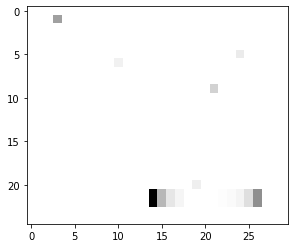

In [7]:
# EM Input Visual
sample_number = 12
energy_snap = EMData[sample_number, 0, :, :]/np.max(EMData[sample_number, 0, :, :])
energy_snap = 1 - energy_snap
energy_snap = np.array(energy_snap * 255, dtype = np.uint8)
energy_snap = cv2.cvtColor(energy_snap, cv2.COLOR_GRAY2BGR)

plt.imshow(energy_snap)

et_vals_em = energy_snap.reshape((-1,1))
et_vals_em = np.float32(et_vals_em)

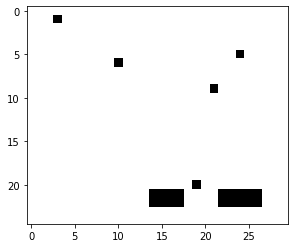

In [33]:
mc_out = EMData[sample_number, 1, :, :]
mc_out = 1 - mc_out
mc_out = np.array(mc_out * 255, dtype = np.uint8)
mc_out = cv2.cvtColor(mc_out, cv2.COLOR_GRAY2BGR)

plt.imshow(mc_out)

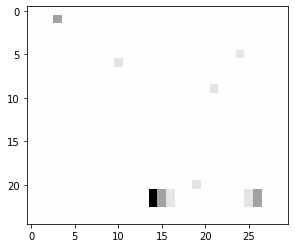

In [34]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.50)
 
k = 4  #background vs signal portion
retval, labels, centers = cv2.kmeans(et_vals_em, k, None, criteria, 30, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((energy_snap.shape))
 
plt.imshow(segmented_image)

In [35]:
# max number of labels belong to background/noise region
bglabel = Counter(labels.flatten()).most_common(1)[-1][0]

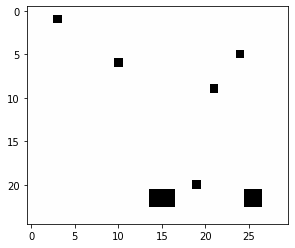

In [36]:
# max number of labels belong to background/noise region
signal_label = list(Counter(labels.flatten()))[-1]

# relabeling the pixels
for i in range(len(labels)):
    if labels[i] != bglabel:
        labels[i] = signal_label

segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((energy_snap.shape))
 
plt.imshow(segmented_image)

In [37]:
segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

In [38]:
np.unique(segmented_image)

array([  0, 254], dtype=uint8)

In [39]:
# generating new labels depending on the clusters formed:
CLUSTER_TAGS = [-1]

def coord_test(x, y):
    if x < 0 or y < 0 or x >= 25 or y >= 30:
        return False
    else:
        True

def check_nearby_ids(mat, x, y):
    dirlt = [-1,0,1]
    for dy in dirlt:
        for dx in dirlt:
            if mat[x-dx][y-dy] < -1:
                return mat[x-dx][y-dy]

    return -1

def cluster_tagging(segmented_image, x, y):
    dirlt = [-1,0,1]
    if coord_test(x, y) == False:
        return segmented_image

    # any positive pixel untouched through implementation stays +ive
    if segmented_image[x][y] in [0, 254]:
        if segmented_image[x][y] == 254:
            # setting cluster id to background
            segmented_image[x][y] = -1
            # print(segmented_image[x][y])
            for dy in dirlt:
                for dx in dirlt:
                    if dx+dy == 0: continue
                    cluster_tagging(segmented_image, x-dx, y-dy)
        
        else:
            adj_id = check_nearby_ids(segmented_image, x, y)
            if adj_id!=-1:
                cluster_id = adj_id
            else: 
                cluster_id = CLUSTER_TAGS[-1] - 1
                CLUSTER_TAGS.append(cluster_id)
                
            segmented_image[x][y] = cluster_id
            for dy in dirlt:
                for dx in dirlt:
                    if dx == 0 and dy == 0: continue
                    cluster_tagging(segmented_image, x-dx, y-dy)
    
    return segmented_image

In [40]:
tagged_pixels = cluster_tagging(np.array(segmented_image, dtype=int), 0, 0)

In [41]:
CLUSTER_TAGS

[-1, -2, -3, -4, -5, -6, -7, -8]

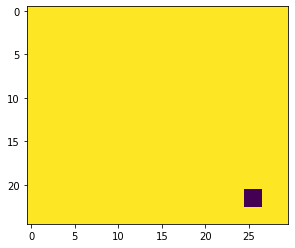

In [43]:
from IPython import display
pause_time = 0.5
for cluster_id in np.unique(tagged_pixels)[:-1]:
    test_out = segmented_image.copy()
    test_out[tagged_pixels != cluster_id] = 254

    plt.imshow(test_out)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(pause_time)

In [16]:
# HD cluster centre selection

tags, tagcount = np.unique(tagged_pixels, return_counts=True)
HDEMClusters = tags[np.where(tagcount == tagcount.min())[0]]
HD_centres = {}
EMHD_coords = []

for cluster_head in HDEMClusters:
    coords = np.where(tagged_pixels == cluster_head)
    EMHD_coords.append((coords[0][0]//5, coords[1][0]//6))

print(EMHD_coords)

for coord in EMHD_coords:
    if coord in HD_centres:
        HD_centres[coord] += 1
    else:
        HD_centres[coord] = 1

[(4, 3), (0, 0), (1, 1), (1, 3), (1, 4)]


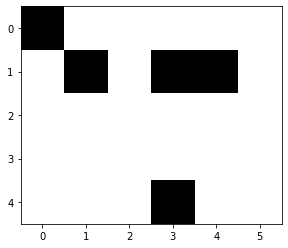

In [17]:
cluster_bkg = np.ones((5,6))
for coords in EMHD_coords:
    cluster_bkg[coords] = 0

cluster_bkg = np.array(cluster_bkg * 255, dtype = np.uint8)
cluster_bkg = cv2.cvtColor(cluster_bkg, cv2.COLOR_GRAY2BGR)
plt.imshow(cluster_bkg)

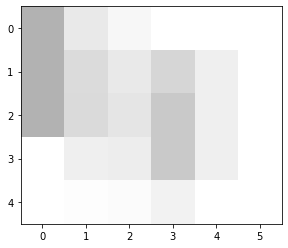

In [18]:
# HD Input Visual
sample_number = 12
energy_snap = HDData[sample_number, 0, :, :]/np.max(HDData[0,0, :, :])
energy_snap = 1 - energy_snap
energy_snap = np.array(energy_snap * 255, dtype = np.uint8)
energy_snap = cv2.cvtColor(energy_snap, cv2.COLOR_GRAY2BGR)
plt.imshow(energy_snap)

et_vals_hd = energy_snap.reshape((-1,1))
et_vals_hd = np.float32(et_vals_hd)

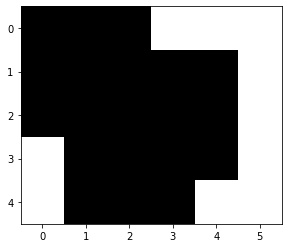

In [19]:
mc_out = HDData[sample_number, 1, :, :]
mc_out = 1 - mc_out
mc_out = np.array(mc_out * 255, dtype = np.uint8)
mc_out = cv2.cvtColor(mc_out, cv2.COLOR_GRAY2BGR)

plt.imshow(mc_out)

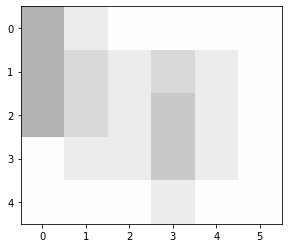

In [20]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.80)
 
k = 5  #background vs signal portion
retval, labels, centers = cv2.kmeans(et_vals_hd, k, None, criteria, 30, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((energy_snap.shape))
 
plt.imshow(segmented_image)

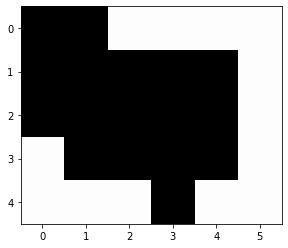

In [21]:
bglabel = Counter(labels.flatten()).most_common(1)[-1][0]

# max number of labels belong to background/noise region
signal_label = list(Counter(labels.flatten()))[1]

# relabeling the pixels
for i in range(len(labels)):
    if labels[i] != bglabel:
        labels[i] = signal_label

segmented_data = centers[labels.flatten()]
segmented_data[segmented_data==segmented_data.min()] = 0
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((energy_snap.shape))
 
plt.imshow(segmented_image)

In [22]:
# classify the HD clusters hits into one of the assumed cluster heads
def tag_HD_Clusters(hd_center_heads, hd_segmented_image):
    HD_ClUSTER_TAGS = {}
    i = -1
    for x in hd_center_heads:
        HD_ClUSTER_TAGS[x] = i
        i = i-1
    
    x_hd, y_hd = hd_segmented_image.shape
    for xi in range(x_hd):
        for yi in range(y_hd):
            if hd_segmented_image[xi][yi] !=0:
                continue
            
            print(xi, yi)
            dist_min, opt_center = 100, None
            for center in HD_ClUSTER_TAGS:
                curr_dist = np.linalg.norm(np.array((xi, yi))-np.array(center))
                print(curr_dist, center)
                if curr_dist < dist_min:
                    opt_center = center
                    curr_dist = dist_min
            
            hd_segmented_image[xi][yi] = HD_ClUSTER_TAGS[opt_center]
    
    return hd_segmented_image


In [23]:
HD_centres

{(4, 3): 1, (0, 0): 1, (1, 1): 1, (1, 3): 1, (1, 4): 1}

In [24]:
segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

In [25]:
tagged_pixels = tag_HD_Clusters(HD_centres, np.array(segmented_image, dtype=int))

0 0
5.0 (4, 3)
0.0 (0, 0)
1.4142135623730951 (1, 1)
3.1622776601683795 (1, 3)
4.123105625617661 (1, 4)
0 1
4.47213595499958 (4, 3)
1.0 (0, 0)
1.0 (1, 1)
2.23606797749979 (1, 3)
3.1622776601683795 (1, 4)
1 0
4.242640687119285 (4, 3)
1.0 (0, 0)
1.0 (1, 1)
3.0 (1, 3)
4.0 (1, 4)
1 1
3.605551275463989 (4, 3)
1.4142135623730951 (0, 0)
0.0 (1, 1)
2.0 (1, 3)
3.0 (1, 4)
1 2
3.1622776601683795 (4, 3)
2.23606797749979 (0, 0)
1.0 (1, 1)
1.0 (1, 3)
2.0 (1, 4)
1 3
3.0 (4, 3)
3.1622776601683795 (0, 0)
2.0 (1, 1)
0.0 (1, 3)
1.0 (1, 4)
1 4
3.1622776601683795 (4, 3)
4.123105625617661 (0, 0)
3.0 (1, 1)
1.0 (1, 3)
0.0 (1, 4)
2 0
3.605551275463989 (4, 3)
2.0 (0, 0)
1.4142135623730951 (1, 1)
3.1622776601683795 (1, 3)
4.123105625617661 (1, 4)
2 1
2.8284271247461903 (4, 3)
2.23606797749979 (0, 0)
1.0 (1, 1)
2.23606797749979 (1, 3)
3.1622776601683795 (1, 4)
2 2
2.23606797749979 (4, 3)
2.8284271247461903 (0, 0)
1.4142135623730951 (1, 1)
1.4142135623730951 (1, 3)
2.23606797749979 (1, 4)
2 3
2.0 (4, 3)
3.60555127

In [26]:
np.unique(tagged_pixels)

array([ -5, 253])

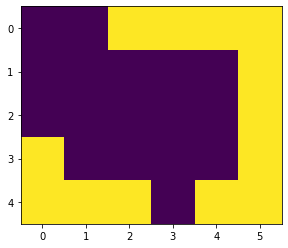

In [27]:
pause_time = 0.5
for cluster_id in np.unique(tagged_pixels)[:-1]:
    test_out = segmented_image.copy()
    test_out[tagged_pixels != cluster_id] = 254

    plt.imshow(test_out)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(pause_time)

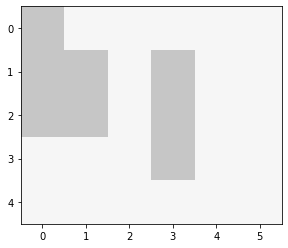

In [87]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
k = 2  #background vs signal portion
retval, labels, centers = cv2.kmeans(et_vals_hd, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((energy_snap.shape))
 
plt.imshow(segmented_image)

In [10]:
# resolution along axes
# recontruction
# position of cluster detected vs real position

# energy_input vs output
# Adding Noise

In [35]:
def kmeans_predict(X):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    k = 2  # background vs signal portion
    _, labels, centers = cv2.kmeans(X, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    return segmented_data

In [47]:
from sklearn.metrics import jaccard_score, accuracy_score, precision_recall_fscore_support

def performance_metrics(y_true, y_pred):
    # segmenation/IoU based
    jsc = jaccard_score(y_true, y_pred, average="weighted")

    # pixel based metrics
    pr, rec, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    return jsc, pr, rec, f1score, acc

In [48]:
def evaluate(XData):
    all_ytrue, all_ypred = [], []
    local_perf = {} # sample_num: performance tuple

    # EM Input Visual
    for sample_number in range(len(XData)):
        energy_snap = EMData[sample_number, 0, :, :]/np.max(XData[sample_number, 0, :, :])
        energy_snap = 1 - energy_snap

        # y_true
        mc_out = XData[sample_number, 1, :, :]
        mc_out = 1 - mc_out
        mc_out = np.float32(mc_out.reshape((-1,1)))

        # image preprocessing
        energy_snap = np.array(energy_snap * 255, dtype = np.uint8)
        energy_snap = cv2.cvtColor(energy_snap, cv2.COLOR_GRAY2BGR)

        x_in = np.float32(energy_snap.reshape((-1,1)))
        y_out = kmeans_predict(x_in)

        # output processing
        y_out = y_out.reshape((energy_snap.shape))
        y_out = cv2.cvtColor(y_out, cv2.COLOR_BGR2GRAY)

        y_pred = y_out > 128
        y_pred = np.float32(y_pred.reshape((-1,1)))

        # evaluating performance
        local_perf[sample_number] = performance_metrics(mc_out, y_pred)
        all_ytrue.extend(mc_out)
        all_ypred.extend(y_pred)

    global_perf = performance_metrics(all_ytrue, all_ypred)

    return local_perf, global_perf

In [50]:
perf_data = evaluate(EMData)

In [65]:
import matplotlib.pyplot as plt

def plot_performance_data(perf_data):
    local, average = perf_data
    data_num = len(local)
    jsc = [local[x][0] for x in local]
    pr = [local[x][1] for x in local]
    rec =  [local[x][2] for x in local]
    f1score = [local[x][3] for x in local]
    acc = [local[x][4] for x in local]

    plt.title("Performance report")
    plt.plot([i for i in range(data_num)], jsc, "r")
    plt.plot([i for i in range(data_num)], f1score, "b")
    plt.plot([i for i in range(data_num)], acc, "g")

    plt.ylabel("error")
    plt.legend(["Jaccard Score", "F1 Score", "Accuracy"])

    plt.show()
    return 0

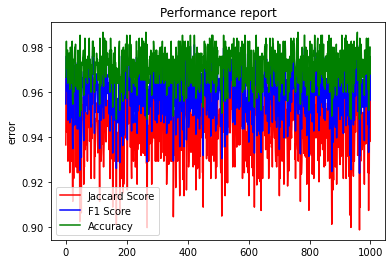

0

In [66]:
plot_performance_data(perf_data)